In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Data Preprocessing

In [63]:
#Inisiasi Data dari .csv
stock1 = pd.DataFrame(pd.read_csv("E:\AKTUARIA SMT 7\SIMULASI AKTUARIA\BBCA.JK.csv", sep=','))
stock2 = pd.DataFrame(pd.read_csv("E:\AKTUARIA SMT 7\SIMULASI AKTUARIA\ICBP.JK.csv", sep=','))
stock3 = pd.DataFrame(pd.read_csv("E:\AKTUARIA SMT 7\SIMULASI AKTUARIA\DCII.JK.csv", sep=','))

#Mengambil data harga saham saat penutupan
close_stock1 = stock1['Close']
close_stock2 = stock2['Close']
close_stock3 = stock3['Close']

#Menggabungkan data harga saham penutupan
data = pd.concat([close_stock1, close_stock2, close_stock3], axis=1)
data.columns = ['BBCA', 'ICBP', 'DCII']

#Mendapatkan tingkat keuntungan (return) berdasarkan harga saham penutupan
return_data = data.pct_change()
return_data = return_data.dropna() #Menghilangkan data dengan value NA
print(return_data)

         BBCA      ICBP      DCII
1   -0.011111  0.004926 -0.002060
2   -0.014045  0.014706 -0.008947
3   -0.011396  0.000000 -0.006944
4   -0.025937 -0.002415 -0.001399
5    0.005917 -0.012107 -0.001401
..        ...       ...       ...
237  0.000000 -0.011848  0.088878
238 -0.005602  0.021583 -0.199627
239  0.000000  0.000000 -0.012821
240  0.002817 -0.014085  0.004132
241  0.008427  0.100000 -0.001176

[241 rows x 3 columns]


# Menentukan Proporsi Saham Terbaik

Proporsi optimal (Markowitz):  [0.30898519 0.34088918 0.35012562]
Return pada Proporsi Optimal:  0.06 %


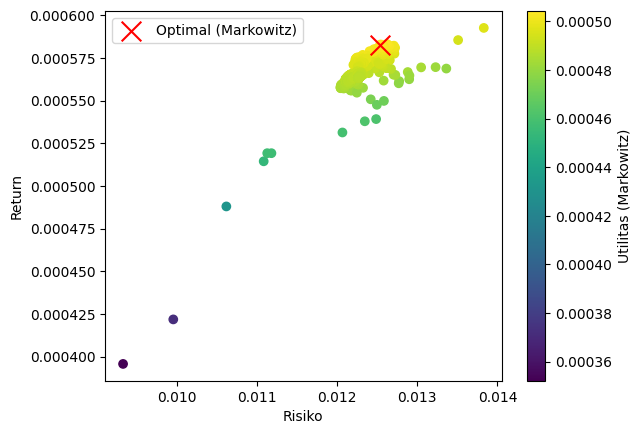

In [65]:
#Inisiasi variabel pendukung
jumlah_data_simulasi = 1000
results = np.zeros((3, jumlah_data_simulasi))
risks = np.zeros(jumlah_data_simulasi)
returns = np.zeros(jumlah_data_simulasi)
dot = []
np.random.seed(1)
#Iterasi untuk generate nilai return gabungan sebanyak jumlah data simulasi yang ditentukan
for i in range(jumlah_data_simulasi):
    proporsi = np.random.random(3)
    proporsi /= np.sum(proporsi)

    for j in range(len(return_data)):
        dot.append(np.dot(proporsi, return_data.iloc[j]))
    
    portfolio_return = np.mean(dot)
    portfolio_risk = np.std(dot)
    
    returns[i] = portfolio_return
    risks[i] = portfolio_risk
    results[0, i] = proporsi[0]
    results[1, i] = proporsi[1]
    results[2, i] = proporsi[2]

utilities = returns - 0.5 * risks**2
max_utility_idx = np.argmax(utilities)
proporsi_optimal = results[:, max_utility_idx]
print('Proporsi optimal (Markowitz): ', proporsi_optimal)
print('Return pada Proporsi Optimal: ', round(returns[max_utility_idx]*100,2), '%')

# Visualisasi hasil simulasi nilai return gabungan
plt.scatter(risks, returns, c=utilities, marker='o', cmap='viridis')
plt.xlabel('Risiko')
plt.ylabel('Return')
plt.colorbar(label='Utilitas (Markowitz)')
plt.scatter(risks[max_utility_idx], returns[max_utility_idx], marker='x', color='red', s=200, label='Optimal (Markowitz)')
plt.legend()
plt.show()

# Monte Carlo Simulation

In [ ]:
#Menggunakan metode Empirical CDF agar distribusi data saham dapat digunakan pada generator angka acak dalam monte carlo 
def ecdf(data):
    sorted_data = np.sort(data)
    n = len(data)
    y = np.arange(1, n + 1) / n
    return sorted_data, y

return_gabungan = np.dot(return_data.values, proporsi_optimal)
x_gabungan, y_gabungan = ecdf(return_gabungan)

#Melakukan simulasi monte carlo terhadap data return gabungan saham dengan proporsi optimal
np.random.seed(1)
montecarlosim = []
for _ in range(len(return_data)):
    uniform_sample = np.random.rand()
    result = np.interp(uniform_sample, y_gabungan, x_gabungan)
    montecarlosim.append(result)
montecarlosim = np.array(montecarlosim)


# Value at Risk

In [ ]:
#Perhitungan Value at Risk awal pada data hasil simulasi monte carlo
alpha = ([0.01, 0.05, 0.10])
val_at_risk = pd.DataFrame()
val_at_risk['Value'] = (montecarlosim.mean() - (montecarlosim.std() * norm.ppf(alpha)))
print(val_at_risk)

      Value
0  0.026041
1  0.018331
2  0.014221


# Perhitungan Variasi Nilai VaR

In [ ]:
#Melakukan simulasi variasi nilai VaR pada tingkat kepercayaan 99%, 95%, dan 90%
def var_variation(ValueatRisk, Iterasi):
    var_table = pd.DataFrame()
    np.random.seed(1)
    #Iterasi untuk mendapatkan variasi nilai VaR secara random
    for i in range(Iterasi):
        random_factors = np.random.rand(ValueatRisk.size) / 100
        variations = ValueatRisk.values.flatten() + random_factors
        var_table[i] = variations
    
    var_table = var_table.T
    return var_table

var_sim = var_variation(val_at_risk, 1000) #Menyimpan nilai VaR hasil simulasi
var_100 = var_sim.mean() * 1000000000 #Mendapatkan nilai VaR apabila investasi sebesar Rp100.000.000,- dilakukan pada portofolio 

C:\Users\rians\AppData\Local\Temp\ipykernel_2088\1789656964.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_table[i] = variations


In [ ]:
def kesimpulan():
    var_mean = pd.DataFrame(var_sim.mean())
    label = pd.DataFrame(alpha)
    var_summary = pd.concat([label, val_at_risk, var_mean, var_100], axis=1)
    var_summary.columns = ['Alpha', 'VaR', 'Mean VaR', 'VaR @Rp100.000.000,-']
    print('Profil Portofolio')
    print('Proporsi Saham Optimal: ', proporsi_optimal)
    print('Expected Return (Mean): ', (round((return_gabungan.mean()*100),3)), '%')
    print('Risiko (Std. Deviasi): ', (round(return_gabungan.std(),3)), '\n')
    print('Evaluasi Hasil Simulasi Monte Carlo')
    print('Expected Return (Mean): ', (round((montecarlosim.mean()*100),3)), '%')
    print('Risiko (Std. Deviasi): ', (round(montecarlosim.std(),3)), '\n')
    print('Evaluasi Perhitungan Value at Risk')
    print(var_summary)

kesimpulan()

Profil Portofolio
Proporsi Saham Optimal:  [0.30898519 0.34088918 0.35012562]
Expected Return (Mean):  0.058 %
Risiko (Std. Deviasi):  0.011 

Evaluasi Hasil Simulasi Monte Carlo
Expected Return (Mean):  -0.028 %
Risiko (Std. Deviasi):  0.011 

Evaluasi Perhitungan Value at Risk
   Alpha       VaR  Mean VaR  VaR @Rp100.000.000,-
0   0.01  0.026041  0.031001          3.100088e+07
1   0.05  0.018331  0.023411          2.341064e+07
2   0.10  0.014221  0.019184          1.918440e+07
